In [16]:
import create_geom_with_pygmsh as cp
import pygmsh
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

In [2]:
import rockhound as rh
from scipy.interpolate import RegularGridInterpolator

def get_topo(lat_min, lat_max, lon_min, lon_max):

    # Load a version of the topography grid
    grid = rh.fetch_etopo1(version="bedrock")

    # Select a subset that corresponds to 
    region = grid.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))

    return region.variables['bedrock'].values, region.variables['latitude'].values, region.variables['longitude'].values

def get_region(ev_lat, ev_lon, stat_lat, stat_lon, offset_lon=0., offset_lat=0.):

    region = dict(
        lat_min = min(ev_lat, stat_lat)-offset_lat,
        lat_max = max(ev_lat, stat_lat)+offset_lat,
        lon_min = min(ev_lon, stat_lon)-offset_lon, 
        lon_max = max(ev_lon, stat_lon)+offset_lon,
    )

    return region

def get_profile(ev_lat, ev_lon, stat_lat, stat_lon, lons, lats, topo, n_pts=100):

    interp = RegularGridInterpolator((lons, lats), topo.T)
    new_lons = np.linspace(ev_lon, stat_lon, n_pts)
    new_lats = np.linspace(ev_lat, stat_lat, n_pts)
    
    return new_lats, new_lons, interp(np.c_[new_lons, new_lats])

ev_lat, ev_lon = -7.45, 121.97
stat_lat, stat_lon = -2., 125.
region = get_region(ev_lat, ev_lon, stat_lat, stat_lon, offset_lon=1., offset_lat=1.)
topo, lats, lons = get_topo(**region)
new_lats, new_lons, profile = get_profile(ev_lat, ev_lon, stat_lat, stat_lon, lons, lats, topo, n_pts=100)

In [3]:
def haversine(lon1, lat1, lon2, lat2, r = 6371.0):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Calculate the result
    return c * r

cpt = 0
dists = np.zeros_like(new_lons)
for lon, lat in zip(new_lons, new_lats):
    dists[cpt] = haversine(new_lons[0], new_lats[0], lon, lat)*1e3
    cpt += 1

-12502.788031552436 570000.9985120173 -50000.0 70000.0


C:\Users\quentin\AppData\Local\Temp\ipykernel_87724\3929555636.py:10: DeprecationWarning: Importing tukey from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.tukey' or the convenience function 'scipy.signal.get_window' instead.
  taper = scipy.signal.tukey(len(z), alpha=0.15)
C:\Users\quentin\AppData\Local\Temp\ipykernel_87724\3929555636.py:69: DeprecationWarning: Importing tukey from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.tukey' or the convenience function 'scipy.signal.get_window' instead.
  taper = 0*scipy.signal.tukey(x_arr.size, alpha=taper_alpha)
C:\Users\quentin\AppData\Local\Temp\ipykernel_87724\3929555636.py:70: DeprecationWarning: Importing tukey from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.tukey' or the convenience function 'scipy.signal.get_window' instead.
  taper_t = 0*scipy.signal.tukey(x_ar

Warning: Appending zeros to replace the missing physical tag data.

Warning: Appending zeros to replace the missing geometrical tag data.

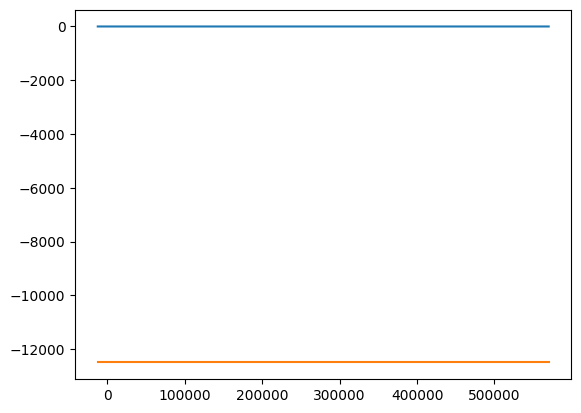

In [79]:
from scipy import interpolate
reload(cp)

use_cpml = True

def my_sinusoidal(x, amplitude=2000, period=40000, depth=16000):

    z = amplitude * np.sin(2 * np.pi * x / period)
    # taper for both ends
    taper = scipy.signal.tukey(len(z), alpha=0.15)
    z *= taper

    return z + depth # average depth is 16000m (z coordinate from the bottom actually)


def create_sinusoidal_subsurface(n_points, xmin, xmax, depth=16000):
    x_arr = np.linspace(xmin, xmax, n_points)
    z_arr = my_sinusoidal(x_arr, depth=depth)

    return x_arr, z_arr

lc_w = 0.5 * 1000.0
lc_g = 2.5 * 1000.0
#xmin, xmax = -10e3, 500e3

xmin, xmax = -12502.788031552436, 567500.9985120173+lc_g
#xmin, xmax = -8008.961858420971, 564606.4158247889
#xmin, xmax = -2500*10., 2500*228#564606.4158247889 ## divider and remainder better
#xmin, xmax = np.round(dists.min()), np.round(dists.max())+1500
#xmin, xmax = np.round(xmin)-1500, np.round(xmax)+1500
zmin, zmax = -50e3, 70e3

"""
lc_select = lc_g
xmin = ((round(abs(xmin) / lc_select)+1) * lc_select)*np.sign(xmin)
xmax = ((round(abs(xmax) / lc_select)+1) * lc_select)*np.sign(xmax)
zmin = (round(abs(zmin) / lc_select) * lc_select)*np.sign(zmin)
zmax = (round(abs(zmax) / lc_select) * lc_select)*np.sign(zmax)
"""
print(xmin, xmax, zmin, zmax)

L = abs(xmax-xmin)
lc_pml = min(lc_w, lc_g)
w_pml = lc_pml*10
H_t = lc_g*5.0 # width of transition layer
nelm_h_g = int(L / lc_g) 
nelm_h_w = int(L / lc_w) 

"""
xmax = xmin + (nelm_h_g-1)*lc_g
L = abs(xmax-xmin)
nelm_h_g = int(L / lc_g) + 1
nelm_h_w = int(L / lc_w) + 1
print(xmax, xmin + (nelm_h_w-1)*lc_w)
print(int(L / lc_g) + 1, nelm_h_g)
"""

lc_b = min(lc_w, lc_g) # element size at boundary
H_w = abs(zmax)  # water depth in meter
H_g = abs(zmin)  # subsurface depth in meter

n_points = int(L / lc_b)
x_arr = np.linspace(xmin, xmax, n_points)
n_points = int(L / lc_g)
x_arr_t = np.linspace(xmin, xmax, n_points)
f = interpolate.interp1d(dists, profile+0*my_sinusoidal(dists, depth=0.), bounds_error=False, fill_value=0.,)

taper_alpha = 0.25
taper = 0*scipy.signal.tukey(x_arr.size, alpha=taper_alpha)
taper_t = 0*scipy.signal.tukey(x_arr_t.size, alpha=taper_alpha)

# Initialize empty geometry using the build in kernel in GMSH
with pygmsh.geo.Geometry() as geom:

    """ node ids without pml layer
    5             6

    4             3
    4t            3t <--- transition layer


    1             2

    """

    # points
    p1 = (xmin, -H_g, 0)
    p2 = (xmax, -H_g, 0)
    p3 = (xmax, 0, 0)
    p4 = (xmin, 0, 0)
    p5 = (xmin, H_w, 0)
    p6 = (xmax, H_w, 0)

    p3t = (xmax, 0 - H_t, 0)
    p4t = (xmin, 0 - H_t, 0)

    #
    # create subsurface geometry
    #
    plt.figure()

    #x_arr, z_arr = create_sinusoidal_subsurface(int(L / lc_b)+1, xmin, xmax, depth=0.)
    #plt.plot(x_arr, z_arr)
    #z_arr = f(x_arr)*taper
    plt.plot(x_arr, f(x_arr)*taper, linestyle='-')
    #plt.plot(x_arr, f(x_arr), linestyle='--')
    topo = {"x": x_arr, "z": f(x_arr)*taper}

    #x_arr_t, z_arr_t = create_sinusoidal_subsurface(int(L / lc_g)+1, xmin, xmax, depth=0.-H_t)
    #plt.plot(x_arr_t, z_arr_t)
    #taper = scipy.signal.tukey(x_arr_t.size, alpha=0.35)
    #z_arr_t = f(x_arr_t)*taper-H_t
    plt.plot(x_arr_t, f(x_arr_t)*taper_t-H_t, linestyle='-')
    #plt.plot(x_arr_t, f(x_arr_t)-H_t, linestyle='--')
    topo_t = {"x": x_arr_t, "z": f(x_arr_t)*taper_t-H_t}
    
    #print(x_arr.size, nelm_h_w)
    #print(x_arr_t.size, nelm_h_g)

    # create rectangles
    whole_domain = cp.rectangles(geom)
    whole_domain.add_one_rect(geom, p1, p2, p3t, p4t, lc_g, transfinite=True, mat_tag="M1", nelm_h=nelm_h_g ,topo=topo_t)
    whole_domain.add_one_rect(geom, p4t, p3t, p3, p4, [lc_g, lc_g, lc_w, lc_w], transfinite=False, mat_tag="M1", topo=topo)
    whole_domain.add_one_rect(geom, p4, p3, p6, p5, lc_w, transfinite=True, nelm_h=nelm_h_w, mat_tag="M2")

    # create pml layer
    if use_cpml:
        whole_domain.add_pml_layers(geom, w_pml, lc_pml, top_pml=True)

    # build up edges and lines
    whole_domain.build_points_edges(geom)

    # force recombine all the surfaces
    import gmsh
    gmsh.initialize()
    gmsh.option.setNumber("Mesh.RecombineAll", 1)
    gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 2)

    # create and write mesh
    mesh = geom.generate_mesh(dim=2, order=1, verbose=True)
    mesh.write("mesh.msh", file_format="gmsh22")


In [73]:
from importlib import reload
import meshio2spec2d
reload(meshio2spec2d)

mio2spec = meshio2spec2d.Meshio2Specfem2D(mesh, outdir = "./test/EXTMSH")
mio2spec.write("extMesh")

Time elapsed for nodes:  1.1536955833435059  seconds
Time elapsed for mesh:  1.3248519897460938  seconds
material keys:  ['M1', 'M2']
cell_id_offset:  3492
Time elapsed for material:  1.0379552841186523  seconds
Time elapsed for surf:  22.614346981048584  seconds
Number of PML_X elements:  3360  ->  3024  ( 336  elements removed)
Number of PML_Y elements:  13264  ->  11892  ( 1372  elements removed)
Number of PML_XY elements:  360  ->  356  ( 4  elements removed)
Time elapsed for cpml:  4.968564033508301  seconds
Time elapsed:  31.10343074798584  seconds
